## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import config
import massbalancemachine as mbm
from collections import defaultdict
import logging
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.xgb_helpers import *
import geopandas as gpd

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(config.SEED)
free_up_cuda()
custom_working_dir = '../../../data/OGGM/'

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_winter = '#a6cee3'
color_annual = '#1f78b4'

# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

# Specify the short names of the climate variables available in the dataset
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

## Input GL data:

In [3]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')

print('Number of glaciers:', len(data_glamos['GLACIER'].unique()))
print('Number of winter and annual samples:', len(data_glamos))
print('Number of annual samples:',
      len(data_glamos[data_glamos.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glamos[data_glamos.PERIOD == 'winter']))

# Capitalize glacier names:
glacierCap = {}
for gl in data_glamos['GLACIER'].unique():
    if isinstance(gl, str):  # Ensure the glacier name is a string
        if gl.lower() == 'claridenu':
            glacierCap[gl] = 'Clariden_U'
        elif gl.lower() == 'claridenl':
            glacierCap[gl] = 'Clariden_L'
        else:
            glacierCap[gl] = gl.capitalize()
    else:
        print(f"Warning: Non-string glacier name encountered: {gl}")

# Glaciers with data of potential clear sky radiation
# Format to same names as stakes:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
]

# Filter out glaciers without data:
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
data_glamos.head(2)

Number of glaciers: 31
Number of winter and annual samples: 31875
Number of annual samples: 7587
Number of winter samples: 24288


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,aspect_sgi,slope_sgi,topo_sgi
0,2006,adler_28,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764,254.483669,19.483581,3039.0,-1.504815,43.181839,3.591626,286.843880,20.604390,3018.033333
1,2006,adler_54,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764,273.466595,12.549861,3091.0,-0.970061,41.090096,0.975349,258.181463,12.582387,3077.711111


In [4]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')


def process_or_load_data(run_flag, data_glamos, paths, config, vois_climate,
                         vois_topographical):
    """
    Process or load the data based on the RUN flag.
    """
    if run_flag:
        logging.info("Number of annual and seasonal samples: %d",
                     len(data_glamos))

        # Filter data
        logging.info("Running on %d glaciers:\n%s",
                     len(data_glamos.GLACIER.unique()),
                     data_glamos.GLACIER.unique())

        # Create dataset
        dataset_gl = mbm.Dataset(data=data_glamos,
                                 region_name='CH',
                                 data_path=paths['csv_path'])
        logging.info("Number of winter and annual samples: %d",
                     len(data_glamos))
        logging.info("Number of annual samples: %d",
                     len(data_glamos[data_glamos.PERIOD == 'annual']))
        logging.info("Number of winter samples: %d",
                     len(data_glamos[data_glamos.PERIOD == 'winter']))

        # Add climate data
        logging.info("Adding climate features...")
        try:
            dataset_gl.get_climate_features(
                climate_data=paths['era5_climate_data'],
                geopotential_data=paths['geopotential_data'],
                change_units=True)
        except Exception as e:
            logging.error("Failed to add climate features: %s", e)
            return None

        # Add radiation data
        logging.info("Adding potential clear sky radiation...")
        logging.info("Shape before adding radiation: %s",
                     dataset_gl.data.shape)
        dataset_gl.get_potential_rad(paths['radiation_save_path'])
        logging.info("Shape after adding radiation: %s", dataset_gl.data.shape)

        # Convert to monthly resolution
        logging.info("Converting to monthly resolution...")
        dataset_gl.convert_to_monthly(meta_data_columns=config.META_DATA,
                                      vois_climate=vois_climate + ['pcsr'],
                                      vois_topographical=vois_topographical)

        # Create DataLoader
        dataloader_gl = mbm.DataLoader(data=dataset_gl.data,
                                       random_seed=config.SEED,
                                       meta_data_columns=config.META_DATA)
        logging.info("Number of monthly rows: %d", len(dataloader_gl.data))
        logging.info("Columns in the dataset: %s", dataloader_gl.data.columns)

        # Save processed data
        output_file = os.path.join(paths['csv_path'],
                                   'CH_wgms_dataset_monthly_full.csv')
        dataloader_gl.data.to_csv(output_file, index=False)
        logging.info("Processed data saved to: %s", output_file)

        return dataloader_gl
    else:
        # Load preprocessed data
        try:
            input_file = os.path.join(paths['csv_path'],
                                      'CH_wgms_dataset_monthly_full.csv')
            data_monthly = pd.read_csv(input_file)
            dataloader_gl = mbm.DataLoader(data=data_monthly,
                                           random_seed=config.SEED,
                                           meta_data_columns=config.META_DATA)
            logging.info("Loaded preprocessed data.")
            logging.info("Number of monthly rows: %d", len(dataloader_gl.data))
            logging.info(
                "Number of annual rows: %d",
                len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
            logging.info(
                "Number of winter rows: %d",
                len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

            return dataloader_gl
        except FileNotFoundError as e:
            logging.error("Preprocessed data file not found: %s", e)
            return None

In [5]:
RUN = False
paths = {
    'csv_path': path_PMB_GLAMOS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc',
    'radiation_save_path': path_pcsr + 'csv/'
}
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     data_glamos=data_glamos,
                                     paths=paths,
                                     config=config,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical)
data_monthly = dataloader_gl.data


2025-02-06 10:33:28,506 - INFO - Loaded preprocessed data.
2025-02-06 10:33:28,508 - INFO - Number of monthly rows: 280720
2025-02-06 10:33:28,537 - INFO - Number of annual rows: 90870
2025-02-06 10:33:28,573 - INFO - Number of winter rows: 189850


### Define test & train glaciers:

In [6]:
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'corvatsch', 'tsanfleuron', 'forno'
]

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

## Grid search:
### Grid search parameters:

In [7]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = config.SEED
param_init["n_jobs"] = config.NUM_JOBS

vois_climate = [
    't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES
print('Running with features:', feature_columns)

Running with features: ['ELEVATION_DIFFERENCE', 't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect_sgi', 'slope_sgi', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'pcsr']


### Correction factors range:

Mean Cprec: 2.3, Mean T_off: 2.03
Min Cprec: 1.3, Max Cprec: 2.3
Min T_off: -0.02, Max T_off: 2.03


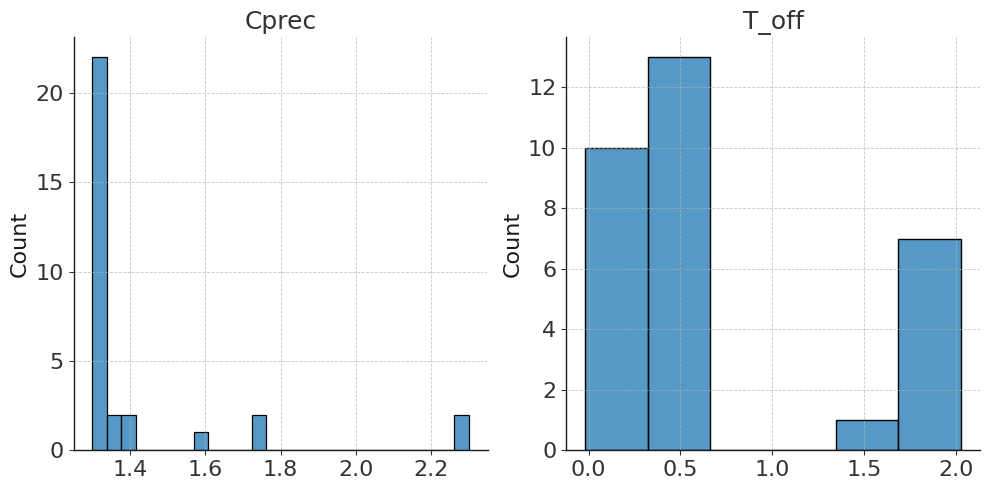

In [8]:
# Load and preprocess GloGEM factors
path_glogem_factors = os.path.join(path_glogem, 'reference_run_GloGEM2024.csv')
glogem_factors = pd.read_csv(path_glogem_factors)
glogem_factors.rename(columns={'ID': 'RGIId'}, inplace=True)
glogem_factors['RGIId'] = glogem_factors['RGIId'].apply(
    lambda x: format_rgi_code(x))

c_prec_dic, t_off_dic = {}, {}
for gl in data_monthly.GLACIER.unique():
    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]
    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]
    c_prec_dic[gl] = factor_gl['Cprec'].values[0]
    t_off_dic[gl] = factor_gl['T_off'].values[0]

# Mean of dic values
mean_c_prec = np.max(list(c_prec_dic.values()))
mean_t_off = np.max(list(t_off_dic.values()))
print(f"Mean Cprec: {mean_c_prec}, Mean T_off: {mean_t_off}")

# Plot range of Cprec and T_off
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(list(c_prec_dic.values()), ax=axes[0])
axes[0].set_title('Cprec')
sns.histplot(list(t_off_dic.values()), ax=axes[1])
axes[1].set_title('T_off')
plt.tight_layout()

# print min and max of Cprec and T_off
print(
    f"Min Cprec: {np.min(list(c_prec_dic.values()))}, Max Cprec: {np.max(list(c_prec_dic.values()))}"
)
print(
    f"Min T_off: {np.min(list(t_off_dic.values()))}, Max T_off: {np.max(list(t_off_dic.values()))}"
)

In [9]:
# Create a range for both parameters:
c_prec_range = np.linspace(1, 3, 10)
t_off_range = np.linspace(0, 3, 10)

### Grid search:

In [10]:
# Number of random combinations to test
N = 10  

# Generate N random combinations of c_prec and t_off
c_prec_samples = np.random.choice(c_prec_range, N, replace=True)
t_off_samples = np.random.choice(t_off_range, N, replace=True)
param_combinations = list(zip(c_prec_samples, t_off_samples))

# Store results
results = []

# Iterate through random parameter combinations
for c_prec, t_off in tqdm(param_combinations, desc="Grid Search Progress"):

    print(f"\nRunning Model for Cprec={c_prec}, T_off={t_off}")

    try:
        # Load or process data
        dataloader_gl = process_or_load_data(
            run_flag=RUN,
            data_glamos=data_glamos,
            paths=paths,
            config=config,
            vois_climate=vois_climate,
            vois_topographical=vois_topographical
        )
        data_monthly = dataloader_gl.data

        # Apply temperature and precipitation correction
        dataloader_gl.correct_for_elevation(c_prec=c_prec, t_off=t_off)

        # Split data into train and test sets based on glaciers
        data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
        data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(train_glaciers)]

        # Cross-validation splits
        splits, test_set, train_set = getCVSplits(
            dataloader_gl, test_split_on="GLACIER", test_splits=test_glaciers
        )

        # Define model parameters (combining base and custom)
        custom_params = {"learning_rate": 0.01, "max_depth": 6, "n_estimators": 800}
        params = {**param_init, **custom_params}

        # Initialize and fit the model
        custom_model = mbm.models.CustomXGBoostRegressor(**params)
        custom_model.fit(train_set["df_X"][all_columns], train_set["y"])

        # Ensure model is set to CPU before prediction
        custom_model = custom_model.set_params(device="cpu")

        # Extract features and metadata
        features_test, metadata_test = custom_model._create_features_metadata(
            test_set["df_X"][all_columns], config.META_DATA
        )

        # Make predictions
        y_pred = custom_model.predict(features_test)

        # Aggregate predictions
        y_pred_agg = custom_model.aggrPredict(metadata_test, config.META_DATA, features_test)

        # Calculate score
        score = custom_model.score(test_set["df_X"][all_columns], test_set["y"])

        # Store results
        results.append({"Cprec": c_prec, "T_off": t_off, "Score": np.abs(score)})

        print(f"Finished Cprec={c_prec}, T_off={t_off} | Score: {np.abs(score):.4f}")

    except Exception as e:
        print(f"Error for Cprec={c_prec}, T_off={t_off}: {e}")

# Convert results to DataFrame and display
df_results = pd.DataFrame(results)

# Save results to CSV
df_results.to_csv("results/grid_search/grid_search_results_tp_tm_corr.csv", index=False)

Grid Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Running Model for Cprec=2.111111111111111, T_off=2.333333333333333


2025-02-06 10:33:30,860 - INFO - Loaded preprocessed data.
2025-02-06 10:33:30,861 - INFO - Number of monthly rows: 280720
2025-02-06 10:33:30,884 - INFO - Number of annual rows: 90870
2025-02-06 10:33:30,914 - INFO - Number of winter rows: 189850


Finished Cprec=2.111111111111111, T_off=2.333333333333333 | Score: 0.3125

Running Model for Cprec=2.111111111111111, T_off=0.3333333333333333


2025-02-06 10:38:40,926 - INFO - Loaded preprocessed data.
2025-02-06 10:38:40,927 - INFO - Number of monthly rows: 280720
2025-02-06 10:38:40,951 - INFO - Number of annual rows: 90870
2025-02-06 10:38:40,983 - INFO - Number of winter rows: 189850


Finished Cprec=2.111111111111111, T_off=0.3333333333333333 | Score: 0.3125

Running Model for Cprec=1.8888888888888888, T_off=0.3333333333333333


2025-02-06 10:43:59,895 - INFO - Loaded preprocessed data.
2025-02-06 10:43:59,896 - INFO - Number of monthly rows: 280720
2025-02-06 10:43:59,919 - INFO - Number of annual rows: 90870
2025-02-06 10:43:59,948 - INFO - Number of winter rows: 189850


Finished Cprec=1.8888888888888888, T_off=0.3333333333333333 | Score: 0.3125

Running Model for Cprec=2.5555555555555554, T_off=1.0


2025-02-06 10:49:10,597 - INFO - Loaded preprocessed data.
2025-02-06 10:49:10,598 - INFO - Number of monthly rows: 280720
2025-02-06 10:49:10,622 - INFO - Number of annual rows: 90870
2025-02-06 10:49:10,653 - INFO - Number of winter rows: 189850


Finished Cprec=2.5555555555555554, T_off=1.0 | Score: 0.3125

Running Model for Cprec=1.4444444444444444, T_off=0.6666666666666666


2025-02-06 10:54:24,252 - INFO - Loaded preprocessed data.
2025-02-06 10:54:24,253 - INFO - Number of monthly rows: 280720
2025-02-06 10:54:24,277 - INFO - Number of annual rows: 90870
2025-02-06 10:54:24,307 - INFO - Number of winter rows: 189850


Finished Cprec=1.4444444444444444, T_off=0.6666666666666666 | Score: 0.3125

Running Model for Cprec=2.111111111111111, T_off=0.6666666666666666


2025-02-06 10:59:30,936 - INFO - Loaded preprocessed data.
2025-02-06 10:59:30,937 - INFO - Number of monthly rows: 280720
2025-02-06 10:59:30,960 - INFO - Number of annual rows: 90870
2025-02-06 10:59:30,991 - INFO - Number of winter rows: 189850


Finished Cprec=2.111111111111111, T_off=0.6666666666666666 | Score: 0.3125

Running Model for Cprec=1.2222222222222223, T_off=1.3333333333333333


2025-02-06 11:04:39,033 - INFO - Loaded preprocessed data.
2025-02-06 11:04:39,034 - INFO - Number of monthly rows: 280720
2025-02-06 11:04:39,057 - INFO - Number of annual rows: 90870
2025-02-06 11:04:39,088 - INFO - Number of winter rows: 189850


Finished Cprec=1.2222222222222223, T_off=1.3333333333333333 | Score: 0.3125

Running Model for Cprec=1.6666666666666665, T_off=1.3333333333333333


2025-02-06 11:09:59,275 - INFO - Loaded preprocessed data.
2025-02-06 11:09:59,276 - INFO - Number of monthly rows: 280720
2025-02-06 11:09:59,299 - INFO - Number of annual rows: 90870
2025-02-06 11:09:59,331 - INFO - Number of winter rows: 189850


Finished Cprec=1.6666666666666665, T_off=1.3333333333333333 | Score: 0.3125

Running Model for Cprec=3.0, T_off=2.0


2025-02-06 11:15:11,499 - INFO - Loaded preprocessed data.
2025-02-06 11:15:11,500 - INFO - Number of monthly rows: 280720
2025-02-06 11:15:11,524 - INFO - Number of annual rows: 90870
2025-02-06 11:15:11,561 - INFO - Number of winter rows: 189850


Finished Cprec=3.0, T_off=2.0 | Score: 0.3125

Running Model for Cprec=2.5555555555555554, T_off=0.0


2025-02-06 11:20:37,070 - INFO - Loaded preprocessed data.
2025-02-06 11:20:37,072 - INFO - Number of monthly rows: 280720
2025-02-06 11:20:37,095 - INFO - Number of annual rows: 90870
2025-02-06 11:20:37,126 - INFO - Number of winter rows: 189850


Finished Cprec=2.5555555555555554, T_off=0.0 | Score: 0.3125


2025-02-06 12:30:00,479 - INFO - Loaded preprocessed data.
2025-02-06 12:30:00,481 - INFO - Number of monthly rows: 280720
2025-02-06 12:30:00,505 - INFO - Number of annual rows: 90870
2025-02-06 12:30:00,536 - INFO - Number of winter rows: 189850


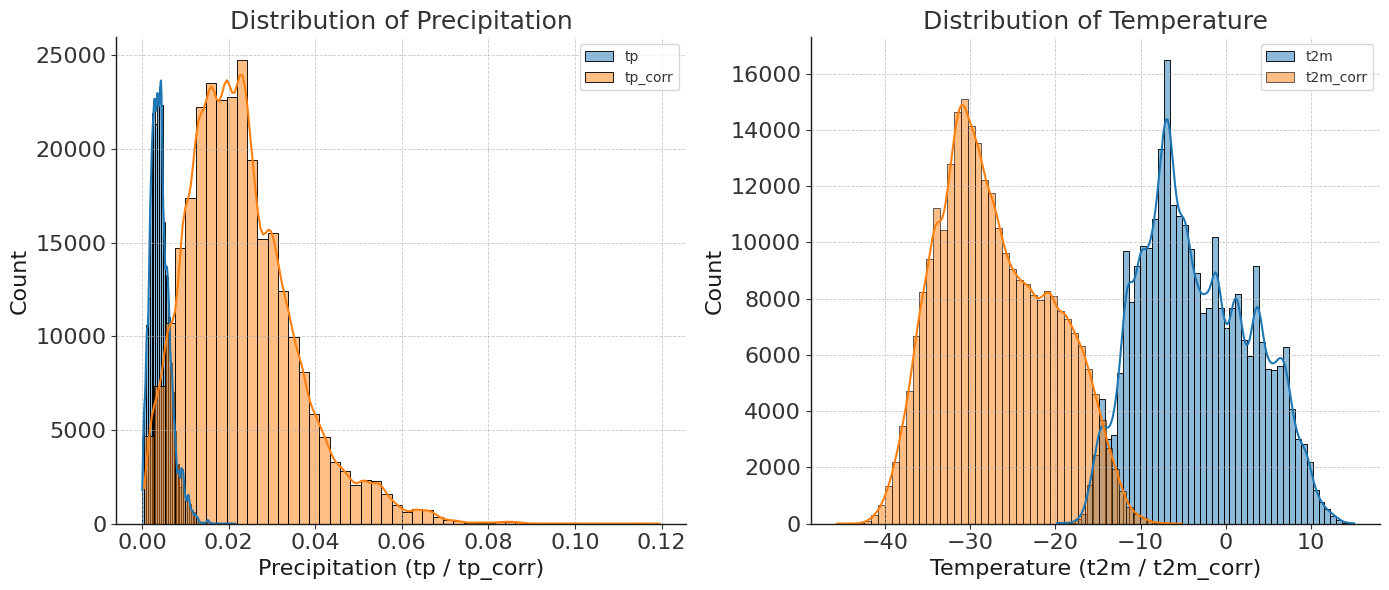

In [15]:
# Load or process data
dataloader_gl = process_or_load_data(
    run_flag=RUN,
    data_glamos=data_glamos,
    paths=paths,
    config=config,
    vois_climate=vois_climate,
    vois_topographical=vois_topographical
)
data_monthly = dataloader_gl.data

# Apply temperature and precipitation correction
dataloader_gl.correct_for_elevation(c_prec=5, t_off=-20)


# Plot the distribution of corrected and uncorrected precipitation and temperature
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Precipitation
sns.histplot(data_monthly['tp'],
             bins=50,
             kde=True,
             label='tp',
             alpha=0.5,
             ax=axes[0])
sns.histplot(data_monthly['tp_corr'],
             bins=50,
             kde=True,
             label='tp_corr',
             alpha=0.5,
             ax=axes[0])
axes[0].set_title('Distribution of Precipitation')
axes[0].set_xlabel('Precipitation (tp / tp_corr)')
axes[0].legend()

# Temperature
sns.histplot(data_monthly['t2m'],
             bins=50,
             kde=True,
             label='t2m',
             alpha=0.5,
             ax=axes[1])
sns.histplot(data_monthly['t2m_corr'],
             bins=50,
             kde=True,
             label='t2m_corr',
             alpha=0.5,
             ax=axes[1])
axes[1].set_title('Distribution of Temperature')
axes[1].set_xlabel('Temperature (t2m / t2m_corr)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [16]:
# Split data into train and test sets based on glaciers
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(train_glaciers)]

# Cross-validation splits
splits, test_set, train_set = getCVSplits(
    dataloader_gl, test_split_on="GLACIER", test_splits=test_glaciers
)

# Define model parameters (combining base and custom)
custom_params = {"learning_rate": 0.01, "max_depth": 6, "n_estimators": 800}
params = {**param_init, **custom_params}

# Initialize and fit the model
custom_model = mbm.models.CustomXGBoostRegressor(**params)
custom_model.fit(train_set["df_X"][all_columns], train_set["y"])

# Ensure model is set to CPU before prediction
custom_model = custom_model.set_params(device="cpu")

# Extract features and metadata
features_test, metadata_test = custom_model._create_features_metadata(
    test_set["df_X"][all_columns], config.META_DATA
)

# Make predictions
y_pred = custom_model.predict(features_test)

# Aggregate predictions
y_pred_agg = custom_model.aggrPredict(metadata_test, config.META_DATA, features_test)

# Calculate score
score = custom_model.score(test_set["df_X"][all_columns], test_set["y"])
score

-0.3125495466104802

In [21]:
all_columns = ['ELEVATION_DIFFERENCE',
 't2m',
 'tp',
 'slhf',
 'sshf',
 'ssrd',
 'fal',
 'str',
 'u10',
 'v10',
 'aspect_sgi',
 'slope_sgi',
 'hugonnet_dhdt',
 'consensus_ice_thickness',
 'millan_v',
 'pcsr',
 'RGIId',
 'POINT_ID',
 'ID',
 'N_MONTHS',
 'MONTHS',
 'PERIOD',
 'GLACIER',
 'POINT_BALANCE',
 'YEAR',
 'POINT_LAT',
 'POINT_LON']

# Split data into train and test sets based on glaciers
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(train_glaciers)]

# Cross-validation splits
splits, test_set, train_set = getCVSplits(
    dataloader_gl, test_split_on="GLACIER", test_splits=test_glaciers
)

# Define model parameters (combining base and custom)
custom_params = {"learning_rate": 0.01, "max_depth": 6, "n_estimators": 800}
params = {**param_init, **custom_params}

# Initialize and fit the model
custom_model = mbm.models.CustomXGBoostRegressor(**params)
custom_model.fit(train_set["df_X"][all_columns], train_set["y"])

# Ensure model is set to CPU before prediction
custom_model = custom_model.set_params(device="cpu")

# Extract features and metadata
features_test, metadata_test = custom_model._create_features_metadata(
    test_set["df_X"][all_columns], config.META_DATA
)

# Make predictions
y_pred = custom_model.predict(features_test)

# Aggregate predictions
y_pred_agg = custom_model.aggrPredict(metadata_test, config.META_DATA, features_test)

# Calculate score
score = custom_model.score(test_set["df_X"][all_columns], test_set["y"])
score

-0.30479718142930573